# Tumor genomic subtype details, FigureS2-9

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import sys,os
from scipy import stats
from collections import Counter
from matplotlib import patches
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.stats.proportion import proportion_confint

In [2]:
print(sys.version)

3.7.4 (default, Jan  6 2021, 18:10:47) 
[Clang 11.0.3 (clang-1103.0.32.29)]


In [3]:
%pip list | grep -e "numpy" -e "pandas" -e "matplotlib" -e "scipy" -e "seaborn" -e "statsmodels"

matplotlib                        3.3.4
numpy                             1.19.5
pandas                            1.2.3
scipy                             1.6.1
seaborn                           0.11.1
statsmodels                       0.12.2
You should consider upgrading via the '/Users/takamatsushiro/.pyenv/versions/3.7.4/envs/MSigPred_2021/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize']=4,3
plt.rcParams['figure.dpi']=300
plt.rcParams['axes.linewidth'] =0.5
plt.rcParams['lines.linewidth'] =0.5
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# set font size
SMALL_SIZE = 7
MEDIUM_SIZE = 8
LARGE_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=LARGE_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('axes', linewidth=0.5) 
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  

In [6]:
store="../results/"

In [7]:
# import data
df=pd.read_csv("../data/TCGA_integrated_data_after_clustering.tsv"
               ,sep="\t",index_col=0,low_memory=False)

In [8]:
# import germline data
germ=pd.read_csv("../data/TCGA_germline_info.tsv",sep="\t",index_col=0)
df=pd.merge(df,germ,left_index=True,right_index=True,how="left")
df[germ.columns]=df[germ.columns].fillna(0)

In [9]:
df["BRCA12_alt"]=(np.nansum(df.reindex(["gBRCA1_LOH","gBRCA2_LOH","sBRCA1_LOH","sBRCA2_LOH","BRCA2_homdel","BRCA1_methylation"],axis=1),axis=1) >=1).astype(float)
df["MMR_mut"]=(np.nansum(df.reindex(["sMMR_mut","gMMR_mut"],axis=1),axis=1) >=1).astype(float)

In [10]:
cluster_colors=['red', 'blue', 'green', "brown", 'purple', 'hotpink',"c",'y']
dict_cluster_colors={"SMK":'red', "UVL":'blue', "APB":'green', "POL":'brown', "MRD":'purple',\
                     "HRD":'hotpink',"GNS":"c","AGE":"y",np.nan:"grey"}
cluster_orders=["SMK","UVL","APB","POL","MRD","HRD","GNS","AGE"]
dict_cluster_order_number={ "SMK":0,"UVL":1,"APB":2,"POL":3,"MRD":4,"HRD":5,"GNS":6,"AGE":7,np.nan:8}

In [11]:
# make cancer colors
rgbs1=sns.color_palette("tab20", 20)
rgbs2=sns.color_palette("tab20b", 20)
rgbs1_3=[] 
for i,x in enumerate(rgbs1):
    if (i%4)!=0:
        rgbs1_3.append(x)
rgbs2_3=[] 
for i,x in enumerate(rgbs2):
    if (i%4)!=0:
        rgbs2_3.append(x)

cancer30_colors = sns.color_palette(rgbs1_3+rgbs2_3, 30)

In [12]:
cancers_freq_order=[x[0] for x in Counter( df["CancerType"]).most_common()]

In [13]:
dict_cancer_colors={ cancer:color for cancer,color in zip(cancers_freq_order,cancer30_colors)}
dict_cancer_colors["Others"]="whitesmoke"
dict_cancer_colors[""]="whitesmoke"

In [14]:
bwr=LinearSegmentedColormap.from_list('bwr', [(0,"blue"),(0.5,"w"),(1,"red")] )
wk=LinearSegmentedColormap.from_list('wk', [(0,"w"),(1,"k")] )
wr=LinearSegmentedColormap.from_list('wr', [(0,"w"),(1,"red")] )

# SMK

In [15]:
df2=df.copy()

In [16]:
df2["SMK"]=(df2["cluster_m2_names"]=="SMK").astype(float)
df2["Sig4_ratio"]=df2["Sig_4"]/df2["total_Sig_count"]*100
np.sum(df2["SMK"])

1072.0

In [17]:
Counter(df2["Smoking4"])

Counter({nan: 6986,
         'ex <15y': 775,
         'current': 680,
         'ex >=15y': 548,
         'never': 805})

In [18]:
df2["Smoking4_order"]=df2["Smoking4"].replace({'ex <15y':3, 'current':4, 'ex >=15y':2, 'never':1})

In [19]:
df_luad=df2[df2["CancerType"]=="LUAD"]
df_lusc=df2[df2["CancerType"]=="LUSC"]
df_hnsc=df2[df2["CancerType"]=="HNSC"]
df_blca=df2[df2["CancerType"]=="BLCA"]

SMK,0.0,1.0
Smoking,,
0.0,124,88
1.0,49,240


Chisquare P= 4.44e-22
Fisher P= 4.65e-22
240/328
49/173


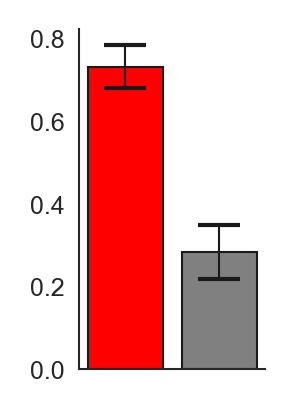

In [20]:
ct=pd.crosstab(df_luad["Smoking"],df_luad["SMK"])
display(ct)
p=stats.chi2_contingency(ct,correction=False)
print("Chisquare P= {:.2e}".format(p[1]) )
p=stats.fisher_exact(ct)
print("Fisher P= {:.2e}".format(p[1]) )

ct=ct[[1,0]]
ratios,errors,labels=[],[],[]
for col in ct.columns:
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,method="binom_test",alpha=0.05)    
    ratios.append(ratio)
    errors.append(np.array(cil-ratio, cih-ratio))
    labels.append(col)
    print(str(count)+"/"+str(nobs))
    
n=len(ratios)
left=range(n)
colors=["red","grey"]
fig=plt.figure(figsize=(n*0.4,1.5))
ax=fig.add_subplot(111)
ax.bar(x=left,height=ratios,yerr=errors,
       tick_label=labels,color=colors,capsize=5,edgecolor="k",linewidth=0.5)
ax.tick_params(labelsize=6)  
ax.set_xticklabels([])#labels, rotation=0, fontsize=8)
ax.legend([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

SMK,0.0,1.0
Smoking,,
0.0,36,67
1.0,65,312


Chisquare P= 9.31e-05
Fisher P= 1.98e-04
312/379
65/101


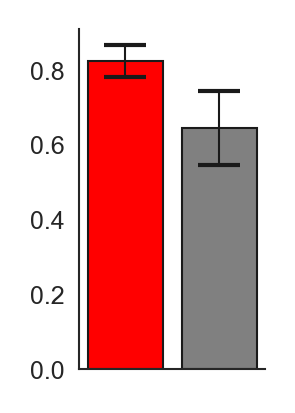

In [21]:
ct=pd.crosstab(df_lusc["Smoking"],df_lusc["SMK"])
display(ct)
p=stats.chi2_contingency(ct,correction=False)
print("Chisquare P= {:.2e}".format(p[1]) )
p=stats.fisher_exact(ct)
print("Fisher P= {:.2e}".format(p[1]) )

ct=ct[[1,0]]
ratios,errors,labels=[],[],[]
for col in ct.columns:
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,method="binom_test",alpha=0.05)    
    ratios.append(ratio)
    errors.append(np.array(cil-ratio, cih-ratio))
    labels.append(col)
    print(str(count)+"/"+str(nobs))

n=len(ratios)
left=range(n)
colors=["red","grey"]
fig=plt.figure(figsize=(n*0.4,1.5))
ax=fig.add_subplot(111)
ax.bar(x=left,height=ratios,yerr=errors,
       tick_label=labels,color=colors,capsize=5,edgecolor="k",linewidth=0.5)
ax.tick_params(labelsize=6)  
ax.set_xticklabels([])#labels, rotation=0, fontsize=8)
ax.legend([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

SMK,0.0,1.0
Smoking,,
0.0,188,3
1.0,246,59


Chisquare P= 5.74e-09
Fisher P= 1.33e-10
59/62
246/434


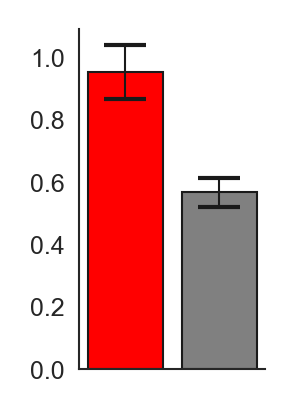

In [22]:
ct=pd.crosstab(df_hnsc["Smoking"],df_hnsc["SMK"])
display(ct)
p=stats.chi2_contingency(ct,correction=False)
print("Chisquare P= {:.2e}".format(p[1]) )
p=stats.fisher_exact(ct)
print("Fisher P= {:.2e}".format(p[1]) )

ct=ct[[1,0]]
ratios,errors,labels=[],[],[]
for col in ct.columns:
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,method="binom_test",alpha=0.05)    
    ratios.append(ratio)
    errors.append(np.array(cil-ratio, cih-ratio))
    labels.append(col)
    print(str(count)+"/"+str(nobs))

n=len(ratios)
left=range(n)
colors=["red","grey"]
fig=plt.figure(figsize=(n*0.4,1.5))
ax=fig.add_subplot(111)
ax.bar(x=left,height=ratios,yerr=errors,
       tick_label=labels,color=colors,capsize=5,edgecolor="k",linewidth=0.5)
ax.tick_params(labelsize=6)  
ax.set_xticklabels([])#labels, rotation=0, fontsize=8)
ax.legend([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

SMK,0.0,1.0
Smoking,,
0.0,230,7
1.0,147,15


Chisquare P= 6.73e-03
Fisher P= 1.22e-02
15/22
147/377


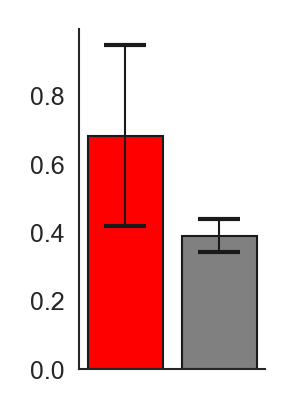

In [23]:
ct=pd.crosstab(df_blca["Smoking"],df_blca["SMK"])
display(ct)
p=stats.chi2_contingency(ct,correction=False)
print("Chisquare P= {:.2e}".format(p[1]) )
p=stats.fisher_exact(ct)
print("Fisher P= {:.2e}".format(p[1]) )

ct=ct[[1,0]]
ratios,errors,labels=[],[],[]
for col in ct.columns:
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,method="binom_test",alpha=0.05)    
    ratios.append(ratio)
    errors.append(np.array(cil-ratio, cih-ratio))
    labels.append(col)
    print(str(count)+"/"+str(nobs))

n=len(ratios)
left=range(n)
colors=["red","grey"]
fig=plt.figure(figsize=(n*0.4,1.5))
ax=fig.add_subplot(111)
ax.bar(x=left,height=ratios,yerr=errors,
       tick_label=labels,color=colors,capsize=5,edgecolor="k",linewidth=0.5)
ax.tick_params(labelsize=6)  
ax.set_xticklabels([])#labels, rotation=0, fontsize=8)
ax.legend([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

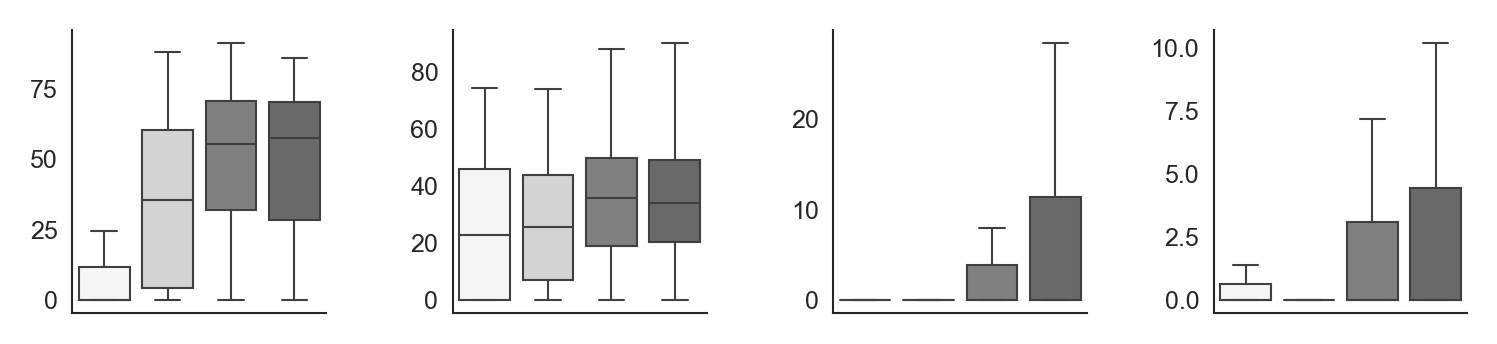

In [24]:
fig = plt.figure(figsize=(6,1.25))
cancers=["LUAD","LUSC","HNSC","BLCA"]
for i,cancer in enumerate(cancers):
    ax=fig.add_subplot(1,4,i+1)
    tmp_df=df2[ df2["CancerType"]==cancer ]
    cat="Smoking4"
    val="Sig4_ratio"
    order=["never",'ex >=15y','ex <15y','current']
    colors=["whitesmoke","lightgrey","grey","dimgrey"]
#    sns.swarmplot(x=cat,y=val,data=tmp_df, palette=colors, order=order,s=1)
    sns.boxplot(x=cat ,y=val,data=tmp_df, palette=colors, order=order, boxprops={"alpha":1},
           sym="")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels([])
    #ax.set_title(cancer,fontsize=8)
    ax.legend([])
    ax.tick_params(axis="both",labelsize=6)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
plt.subplots_adjust(wspace=0.5)

In [25]:
df2["ID3_ratio"]=df2["ID3"]/df2["total_all_mut"]*100

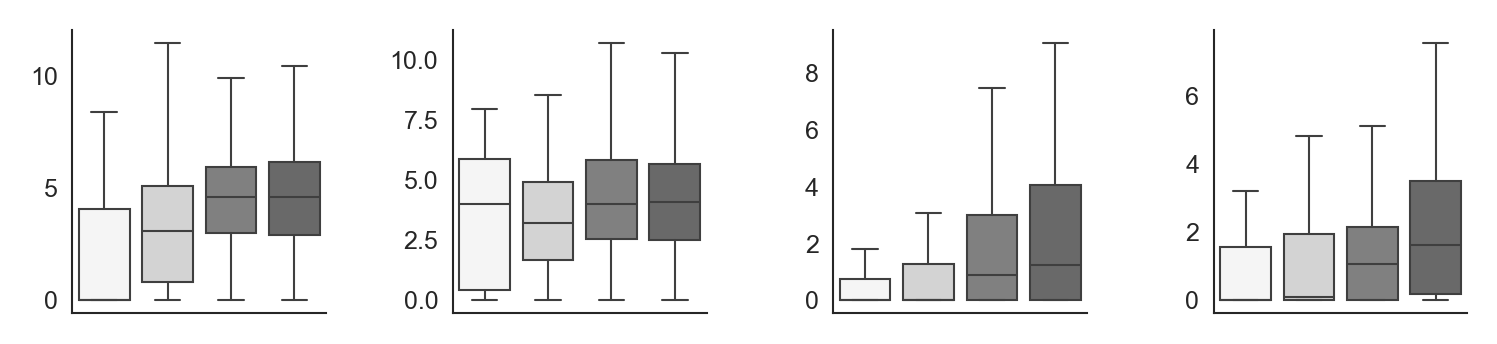

In [26]:
fig = plt.figure(figsize=(6,1.25))
cancers=["LUAD","LUSC","HNSC","BLCA"]
for i,cancer in enumerate(cancers):
    ax=fig.add_subplot(1,4,i+1)
    tmp_df=df2[ df2["CancerType"]==cancer ]
    cat="Smoking4"
    val="ID3_ratio"
    order=["never",'ex >=15y','ex <15y','current']
    colors=["whitesmoke","lightgrey","grey","dimgrey"]
#    sns.swarmplot(x=cat,y=val,data=tmp_df, palette=colors, order=order,s=1)
    sns.boxplot(x=cat ,y=val,data=tmp_df, palette=colors, order=order, boxprops={"alpha":1},
           sym="")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels([])
    #ax.set_title(cancer,fontsize=8)
    ax.legend([])
    ax.tick_params(axis="both",labelsize=6)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
plt.subplots_adjust(wspace=0.5)

In [27]:
# write out for JT test for R 
dfw=df2[["Smoking4_order","CancerType","Sig4_ratio","ID3_ratio"]]
dfw=dfw[ dfw["CancerType"].isin(["LUAD","LUSC","HNSC","BLCA"])]
dfw.to_csv("../analysis_in_R/"+"TCGA_smoking4_Sig4_ID3_for_JT_test.tsv",sep="\t")

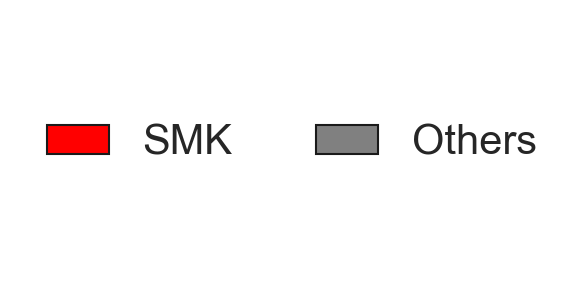

In [28]:
plt.figure(figsize=(1,1))
names=["SMK","Others"]
colors=["red","grey"]
custom_legends =[  Patch(facecolor=colors[i],edgecolor="k",linewidth=0.5,
   			label=names[i]) for i in range(len(names)) ]
plt.legend(handles=custom_legends,loc="center",fontsize=10,ncol=2,handlelength=1.5)
plt.gca().set_axis_off()
#plt.savefig(store+"patch_smoking_status.png",dpi=300,bbox_inches="tight")

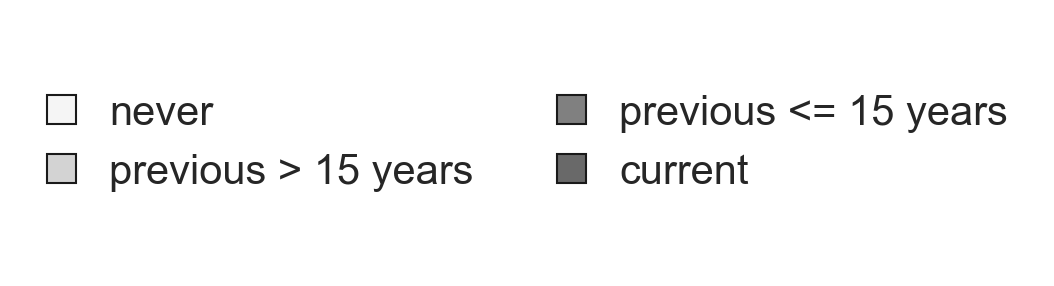

In [29]:
plt.figure(figsize=(1,1))
names=["never", "previous > 15 years","previous <= 15 years", "current"]
colors=["whitesmoke","lightgrey","grey","dimgrey"]
custom_legends =[  Patch(facecolor=colors[i],edgecolor="k",linewidth=0.5,
   			label=names[i]) for i in range(4) ]
plt.legend(handles=custom_legends,loc="center",fontsize=10,ncol=2,handlelength=0.7)
plt.gca().set_axis_off()
#plt.savefig(store+"patch_smoking_status.png",dpi=300,bbox_inches="tight")

# UVL

In [30]:
df2["UVL"]=(df2["cluster_m2_names"]=="UVL").astype(int)
df2["SKCM"]=(df2["CancerType"]=="SKCM").astype(int)
df2["Sig7_ratio"]=df2["Sig_7"]/df2["total_Sig_count"]*100
df_skcm=df2[ (df2["SKCM"]==1)]
df_nonskcm=df2[ (df2["SKCM"]==0)]

P= 0.0018
P= 0.033


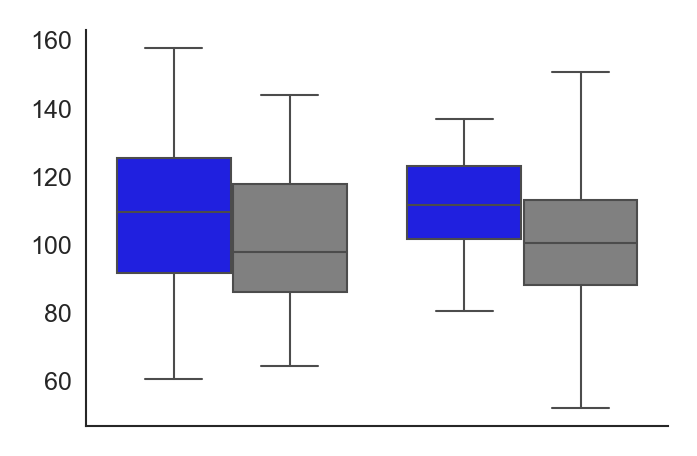

In [31]:
fig=plt.figure(figsize=(2.5,1.75))
ax=fig.add_subplot(111)
sns_df=df2.copy()
cat="SKCM"
val="GEP_score"
hue="UVL"

ax=sns.boxplot(x=cat,y=val,data=sns_df,hue=hue,sym="",boxprops={"alpha":1},palette=["blue","grey"],
              order=[1,0],hue_order=[1,0])
#ax=sns.swarmplot(x=cat,y=val,data=sns_df,s=2,hue=hue,dodge=True,palette=["grey","green"])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("",fontsize=10)
ax.set_xticklabels([])
ax.legend([])
ax.tick_params(axis="both",labelsize=6)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

a=sns_df[ (sns_df[cat]==1) & (sns_df[hue]==1)][val]
b=sns_df[ (sns_df[cat]==1) & (sns_df[hue]==0)][val]
c=sns_df[ (sns_df[cat]==0) & (sns_df[hue]==1)][val]
d=sns_df[ (sns_df[cat]==0) & (sns_df[hue]==0)][val]

_,p1=stats.mannwhitneyu(a,b)
_,p2=stats.mannwhitneyu(c,d)
print("P= {:.4f}".format(p1))
print("P= {:.3f}".format(p2))

P= 0.0160
P= 0.026


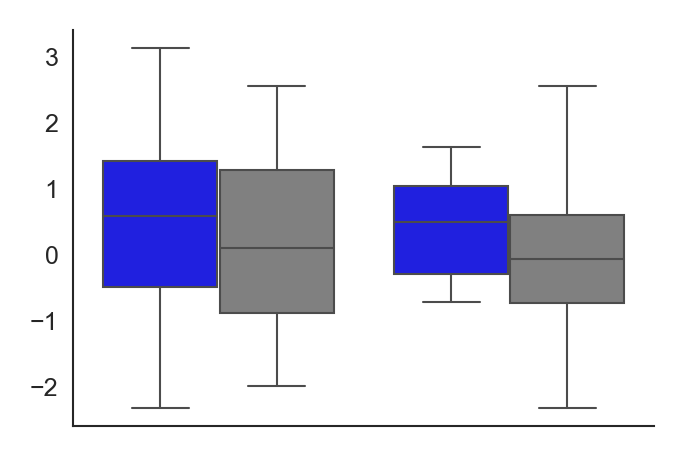

In [32]:
fig=plt.figure(figsize=(2.5,1.75))
ax=fig.add_subplot(111)
sns_df=df2.copy()
cat="SKCM"
val="PDCD1_log_z"
hue="UVL"

ax=sns.boxplot(x=cat,y=val,data=sns_df,hue=hue,sym="",boxprops={"alpha":1},palette=["blue","grey"],
              order=[1,0],hue_order=[1,0])
#ax=sns.swarmplot(x=cat,y=val,data=sns_df,s=2,hue=hue,dodge=True,palette=["grey","green"])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("",fontsize=10)
ax.set_xticklabels([])
ax.legend([])
ax.tick_params(axis="both",labelsize=6)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

a=sns_df[ (sns_df[cat]==1) & (sns_df[hue]==1)][val]
b=sns_df[ (sns_df[cat]==1) & (sns_df[hue]==0)][val]
c=sns_df[ (sns_df[cat]==0) & (sns_df[hue]==1)][val]
d=sns_df[ (sns_df[cat]==0) & (sns_df[hue]==0)][val]

_,p1=stats.mannwhitneyu(a,b)
_,p2=stats.mannwhitneyu(c,d)
print("P= {:.4f}".format(p1))
print("P= {:.3f}".format(p2))

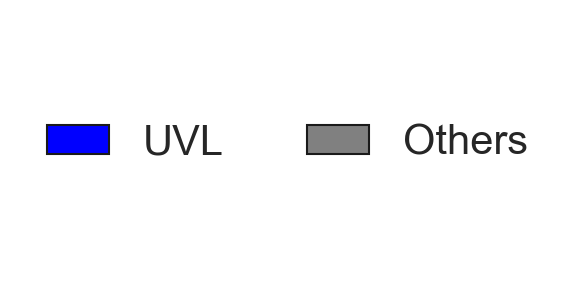

In [33]:
plt.figure(figsize=(1,1))
names=["UVL","Others"]
colors=["blue","grey"]
custom_legends =[  Patch(facecolor=colors[i],edgecolor="k",linewidth=0.5,
   			label=names[i]) for i in range(len(names)) ]
plt.legend(handles=custom_legends,loc="center",fontsize=10,ncol=2,handlelength=1.5)
plt.gca().set_axis_off()
#plt.savefig(store+"patch_smoking_status.png",dpi=300,bbox_inches="tight")

# APB

In [34]:
df2["APB"]=(df2["cluster_m2_names"]=="APB").astype(float)
df2["APOBEC_Sigs_ratio"]=df2["APOBEC_Sigs"]/df2["total_Sig_count"]*100
df2["APB"].sum()

1036.0

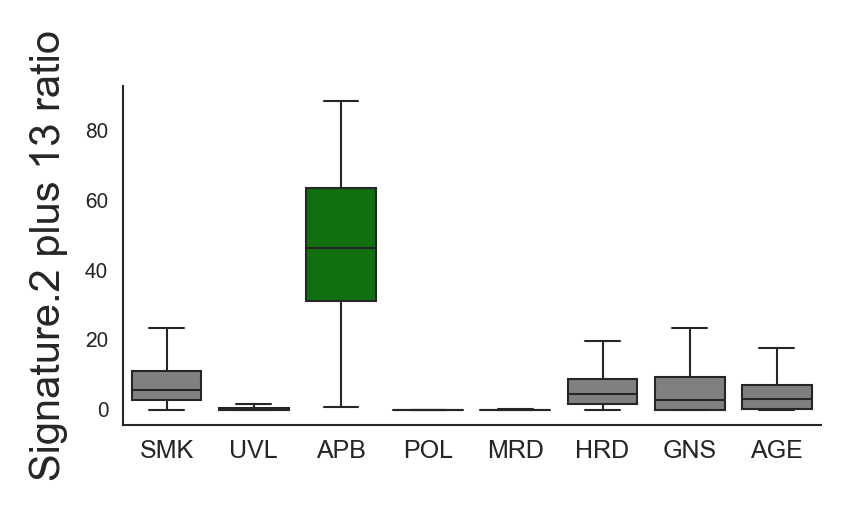

In [35]:
fig=plt.figure(figsize=(3,1.5))
ax=fig.add_subplot(111)
sns_df=df2.copy()
cat="cluster_m2_names"
val="APOBEC_Sigs_ratio"
colors=["grey"]*2+["green"]+["grey"]*5
ax=sns.boxplot(x=cat,y=val,data=sns_df,sym="",boxprops={"alpha":1},palette=colors)

ax.set_xlabel("")
ax.set_ylabel("Signature.2 plus 13 ratio",fontsize=10)
ax.set_title("",fontsize=10)
ax.tick_params(axis="y",labelsize=5)
ax.tick_params(axis="x",labelsize=6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [36]:
apb3_gexp_list=df2.columns[df2.columns.str.contains("APOBEC3.*_log")]
apb3_gexp_list_z=[x+"_z" for x in apb3_gexp_list]
for x in apb3_gexp_list:
    df2[x+"_z"]=stats.zscore(df2[x],nan_policy="omit")

In [37]:
fig=plt.figure(figsize=(1.75,4.5))
vals=apb3_gexp_list_z
for i,val in enumerate(vals):
    ax=fig.add_subplot(len(vals),1,i+1)
    data=df2
    ax=sns.boxplot(x=val,y="APB",data=data,palette=["green","grey"],sym="",order=[1,0],orient="h",width=0.7)
    ax.set_ylabel(val.replace("_log_z",""),fontsize=10,rotation=0,ha="right",va="center")
    ax.set_xlim(-3.5,4.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel("")
    if i ==0 :
        ax.set_xticks([-3,0,3])
        ax.set_xticklabels([-3,0,3])
        ax.xaxis.tick_top()
    else:
        ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    #ax.spines["left"].set_visible(False)
    ax.tick_params(labelsize=6)

    
    a=data[data["APB"]==0][val].values
    b=data[data["APB"]==1][val].values
    s,pb=stats.mstats.brunnermunzel(a,b)
    s,pm=stats.mstats.mannwhitneyu(a,b)
    #print("P= {:.2e}".format(pb))
    print("P= {:.2e}".format(pm))
    
plt.subplots_adjust(hspace=0.1)

<Figure size 525x1350 with 0 Axes>

In [38]:
irs_list=["CYT_log","GEP_score","HALLMARK_INTERFERON_GAMMA_RESPONSE"]
irs_list_z=[x+"_z" for x in irs_list]
for x in irs_list:
    df2[x+"_z"]=stats.zscore(df2[x],nan_policy="omit")

P= 6.87e-11
P= 3.85e-18
P= 1.47e-50
CYT_log_z
GEP_score_z
HALLMARK_INTERFERON_GAMMA_RESPONSE_z


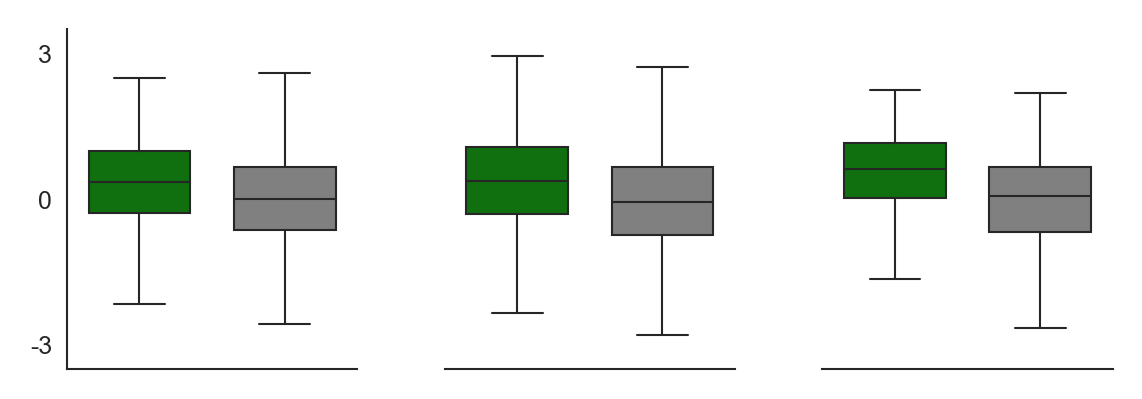

In [39]:
fig=plt.figure(figsize=(4.5,1.5))
vals=irs_list_z
for i,val in enumerate(vals):
    ax=fig.add_subplot(1,len(vals),i+1)
    data=df2
    ax=sns.boxplot(x="APB",y=val,data=data,palette=["green","grey"],sym="",order=[1,0],width=0.7)
    ax.set_xlabel("")
    ax.set_ylim(-3.5,3.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_ylabel("")
    if i ==0 :
        ax.set_yticks([-3,0,3])
        ax.set_yticklabels([-3,0,3])
        #ax.xaxis.tick_top()
    else:
        ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    #ax.spines["left"].set_visible(False)
    ax.tick_params(labelsize=6)

    
    a=data[data["APB"]==0][val].values
    b=data[data["APB"]==1][val].values
    s,pb=stats.mstats.brunnermunzel(a,b)
    s,pm=stats.mstats.mannwhitneyu(a,b)
    #print("P= {:.2e}".format(pb))
    print("P= {:.2e}".format(pm))
    
plt.subplots_adjust(wspace=0.3)

for val in vals:
    print(val)

In [40]:
input_df=df2[~df2["cluster_m2_names"].isin(["MRD","POL"])]

74/1072
4/401
274/1036
160/1956
33/909
493/4000
APB vs AGE P=1.74e-29


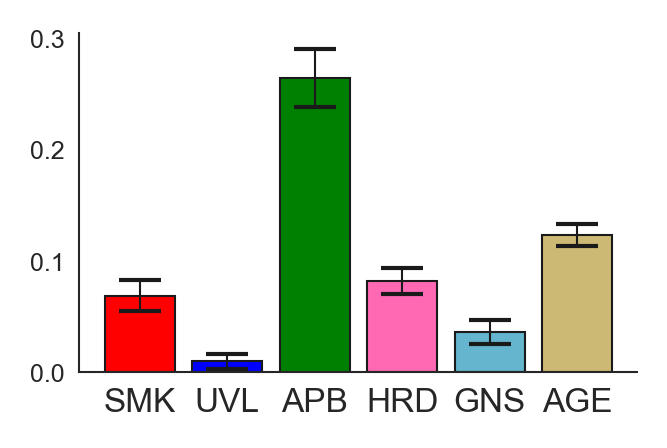

In [41]:
ct=pd.crosstab(input_df["sPIK3CA_mut"],input_df["cluster_m2_names"])
ct=ct[["SMK","UVL","APB","HRD","GNS","AGE"]]

ratios,errors,labels=[],[],[]
for col in ct.columns:
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,method="binom_test",alpha=0.05)    
    ratios.append(ratio)
    errors.append(np.array(cil-ratio, cih-ratio))
    labels.append(col)
    print(str(count)+"/"+str(nobs))

n=len(ratios)
left=range(n)
colors=[dict_cluster_colors[cluster] for cluster in ct.columns]

fig=plt.figure(figsize=(n*0.4,1.5))
ax=fig.add_subplot(111)
ax.bar(x=left,height=ratios,yerr=errors,
       tick_label=labels,color=colors,capsize=5,edgecolor="k",linewidth=0.5)
ax.tick_params(labelsize=6)  
ax.set_xticklabels(labels, rotation=0, fontsize=8)
ax.legend([])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ct2=ct.loc[:,["APB","AGE"]]
res=stats.chi2_contingency(ct2,correction=False)
print("APB vs AGE P={:.2e}".format(res[1]))

In [42]:
df2["HALLMARK_PI3K_AKT_MTOR_SIGNALING_z"]=stats.zscore(df2["HALLMARK_PI3K_AKT_MTOR_SIGNALING"],nan_policy="omit")

P= 2.31e-18


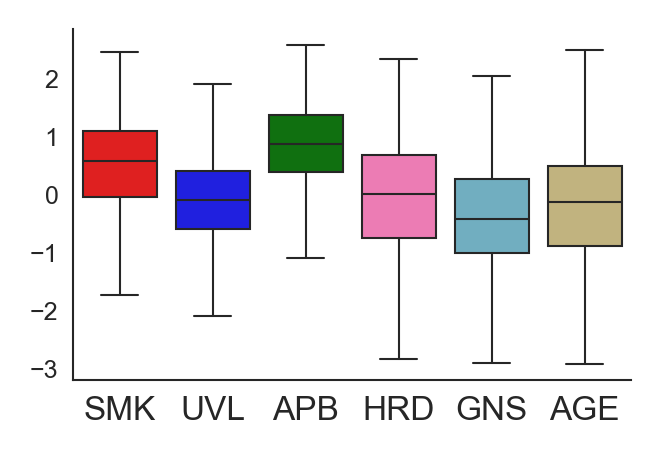

In [43]:
fig=plt.figure(figsize=(2.4,1.55))
ax=fig.add_subplot(111)
sns_df=df2.copy()
cat="cluster_m2_names"
val="HALLMARK_PI3K_AKT_MTOR_SIGNALING_z"
order=["SMK","UVL","APB","HRD","GNS","AGE"]
colors=[dict_cluster_colors[cluster] for cluster in order]

ax=sns.boxplot(x=cat,y=val,data=sns_df,sym="",order=order,palette=colors)#
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("",fontsize=10)
ax.legend([])
ax.tick_params(axis="both",labelsize=6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels(order, rotation=0, fontsize=8)

a=sns_df[sns_df[cat]=="SMK"][val].values
b=sns_df[sns_df[cat]=="APB"][val].values

s,pb=stats.mstats.brunnermunzel(a,b)
s,pm=stats.mstats.mannwhitneyu(a,b)
#print("P= {:.2e}".format(pb))
print("P= {:.2e}".format(pm))

507
P= 0.41
P= 1.95e-05
P= 1.03e-03


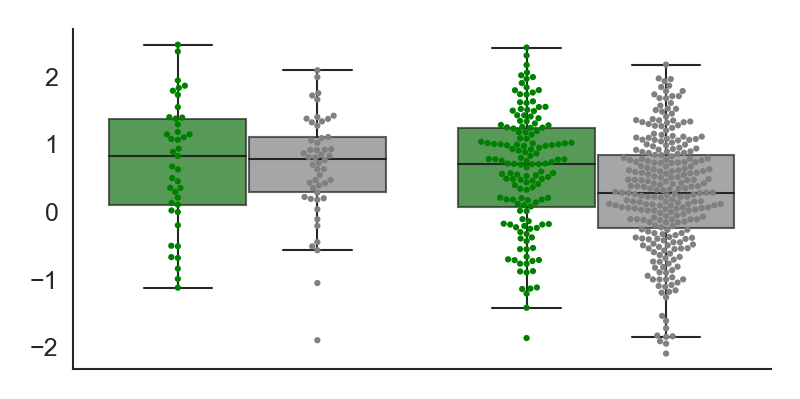

In [44]:
fig=plt.figure(figsize=(3,1.5))
ax=fig.add_subplot(111)
sns_df=df2[df2["CancerType"]=="HNSC"].copy()
print(len(sns_df))
cat="HPV_status"
val="CYT_log_z"
hue="APB"
ax=sns.boxplot(x=cat,y=val,data=sns_df,hue=hue,hue_order=[1,0],sym="",boxprops={"alpha":0.7},palette=["green","grey"],
              order=[1,0])
ax=sns.swarmplot(x=cat,y=val,data=sns_df,s=1.5,hue=hue, hue_order=[1,0],dodge=True,palette=["green","grey"],order=[1,0])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("",fontsize=10)
ax.set_xticklabels([])
ax.legend([])
ax.tick_params(axis="both",labelsize=6)


a=sns_df[(sns_df[cat]==1)&(sns_df[hue]==1)][val]
b=sns_df[(sns_df[cat]==1)&(sns_df[hue]==0)][val]
c=sns_df[(sns_df[cat]==0)&(sns_df[hue]==1)][val]
d=sns_df[(sns_df[cat]==0)&(sns_df[hue]==0)][val]
_,p1=stats.mannwhitneyu(a,b)
_,p2=stats.mannwhitneyu(c,d)

print("P= {:.2f}".format(p1))
print("P= {:.2e}".format(p2))

e=np.concatenate([a.values,b.values])
f=np.concatenate([c.values,d.values])
_,p3=stats.mannwhitneyu(e,f)
print("P= {:.2e}".format(p3))


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [45]:
cptac=pd.read_csv("../data/CPTAC_tgs_irs.tsv",sep="\t",index_col=0)
cptac["APB"]=(cptac["Cons"]=="APB").astype(float)

MannwhitneyuResult(statistic=1005.0, pvalue=0.07834745458929739)
BrunnerMunzelResult(statistic=-1.488411654157769, pvalue=0.14093892800235527)


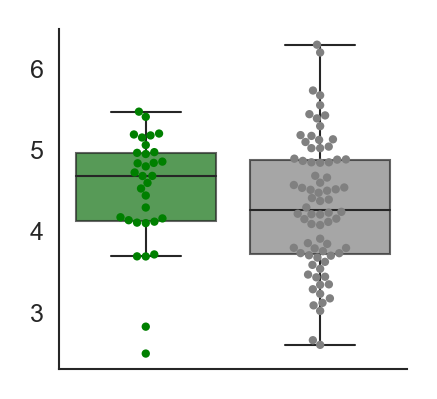

In [46]:
fig=plt.figure(figsize=(1.5,1.5))
ax=fig.add_subplot(111)
sns_df=cptac[cptac["CancerType2"]=="HNC"].copy()
cat="APB"
val="CYT_log"
ax=sns.boxplot(x=cat,y=val,data=sns_df,sym="",boxprops={"alpha":0.7},palette=["green","grey"],
              order=[1,0])
ax=sns.swarmplot(x=cat,y=val,data=sns_df,s=2,palette=["green","grey"],
              order=[1,0])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
ax.set_title("",fontsize=10)
ax.legend([])
ax.tick_params(axis="both",labelsize=6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

a=sns_df[sns_df[cat]==1][val]
b=sns_df[sns_df[cat]==0][val]
print(stats.mannwhitneyu(a,b))
print(stats.brunnermunzel(a,b,nan_policy="omit"))

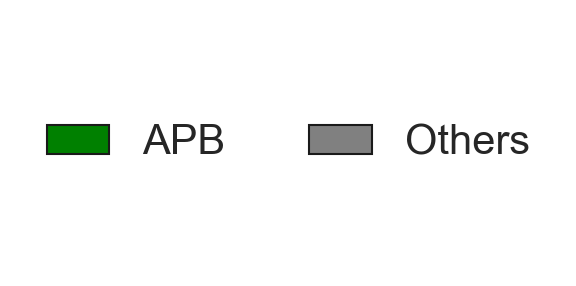

In [47]:
plt.figure(figsize=(1,1))
names=["APB","Others"]
colors=["green","grey"]
custom_legends =[  Patch(facecolor=colors[i],edgecolor="k",linewidth=0.5,
   			label=names[i]) for i in range(len(names)) ]
plt.legend(handles=custom_legends,loc="center",fontsize=10,ncol=2,handlelength=1.5)
plt.gca().set_axis_off()
#plt.savefig(store+"patch_smoking_status.png",dpi=300,bbox_inches="tight")

# MRD

In [48]:
df2["MRD"]=(df2["cluster_m2_names"]=="MRD").astype(float)
df2["POL"]=(df2["cluster_m2_names"]=="POL").astype(float)
df2["MRD_POL"]=((df2["POL"]==1)|(df2["MRD"]==1)).astype(float)
df2["MSI_associated_cancer"]=(df2["CancerType"].isin(["UCEC","CRC","STAD","ESCA"])).astype(float)
df2["POL_Sig_ratio"]=df2["POLE_Sigs"]/df2["total_Sig_count"]*100
df2["MRD_Sig_ratio"]=df2["MMRD_Sigs"]/df2["total_Sig_count"]*100
df2["aMMR"]=((df2["MMR_mut"]==1)|(df2["MLH1_methylation"]==1)).astype(float)
print(df2["MRD"].sum())

339.0


In [49]:
pd.crosstab( df2["MRD"], df2["aMMR"] )

aMMR,0.0,1.0
MRD,,
0.0,9265,190
1.0,46,293


In [50]:
df2["sMMR_mut"]=df2["sMMR_mut"].fillna(0)

/Users/takamatsushiro/.pyenv/versions/3.7.4/envs/MSigPred_2021/lib/python3.7/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


sMMR_mut
gMMR_mut
MLH1_methylation
MSI_high


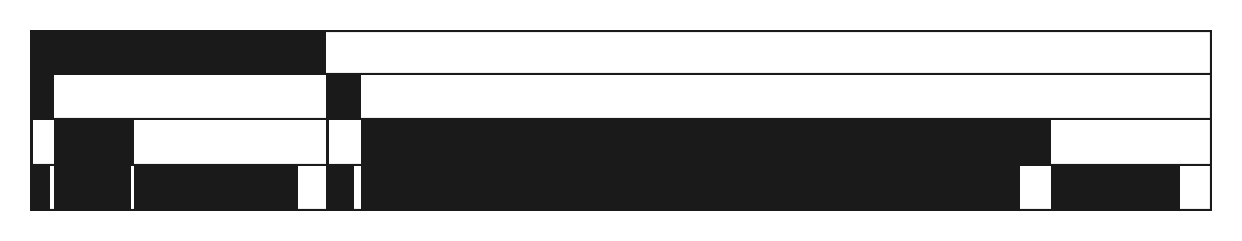

In [51]:
cat_list=["sMMR_mut","gMMR_mut", "MLH1_methylation","MSI_high"]
n=len(cat_list)
input_df=df2[df2["MRD"]==1]
input_df[cat_list]=input_df[cat_list].fillna(0)
input_df=input_df.sort_values(cat_list,ascending=False)
N=input_df.shape[0]
fig=plt.figure(figsize=(N*0.015, 0.2*n))
for i,cat in enumerate(cat_list):
    ax=fig.add_subplot(n,1,i+1)
    print(cat)
    sns.heatmap(input_df[[cat]].T,cmap=wk,vmin=0,vmax=1,xticklabels=0,yticklabels=0,cbar=False,ax=ax)
    if i==0:
        ax.axhline(y=0, color='k',linewidth=1)
    ax.axhline(y=1, color='k',linewidth=1)
    ax.axvline(x=0, color='k',linewidth=1)
    ax.axvline(x=N, color='k',linewidth=1)
        
plt.subplots_adjust(hspace=0)

In [52]:
tmp=df2[df2["MRD"]==1].groupby("CancerType").count()["cluster_m2_names"].sort_values(ascending=False)
pd.DataFrame(tmp)

,cluster_m2_names
CancerType,
UCEC,139
STAD,80
CRC,74
BRCA,8
CESC,6
ACC,4
HNSC,4
GBM,3
SARC,3


P= 2.13e-21
P= 0.016


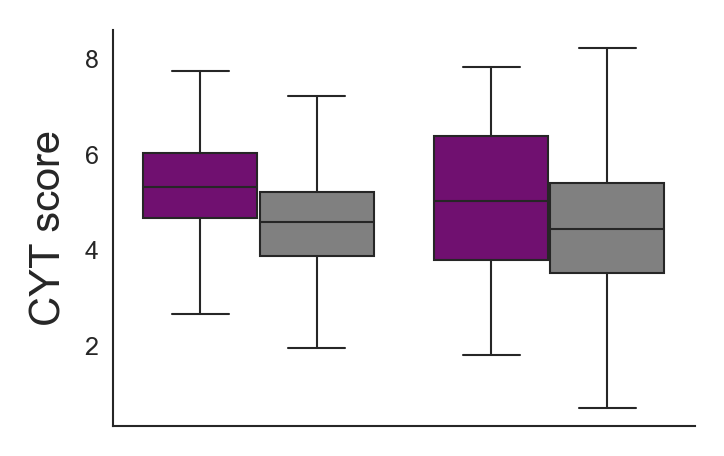

In [53]:
fig=plt.figure(figsize=(2.5,1.75))
ax=fig.add_subplot(1,1,1)
input_df=df2.copy()
x="MSI_associated_cancer"
y="CYT_log"
hue="MRD"
ax=sns.boxplot(x=x,y=y,data=input_df,hue=hue,sym="",palette=["purple","grey"],order=[1,0],hue_order=[1,0])
ax.legend([])
ax.set_xlabel("")
ax.set_xticklabels([])
ax.set_ylabel("CYT score",fontsize=10)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(labelsize=6)

a=input_df[(input_df[x]==True)&(input_df[hue]==True)][y].values
b=input_df[(input_df[x]==True)&(input_df[hue]==False)][y].values
c=input_df[(input_df[x]==False)&(input_df[hue]==True)][y].values
d=input_df[(input_df[x]==False)&(input_df[hue]==False)][y].values

_,p1=stats.mannwhitneyu(a,b)
_,p2=stats.mannwhitneyu(c,d)

print("P= {:.2e}".format(p1))
print("P= {:.3f}".format(p2))

P= 9.39e-121
P= 4.01e-08


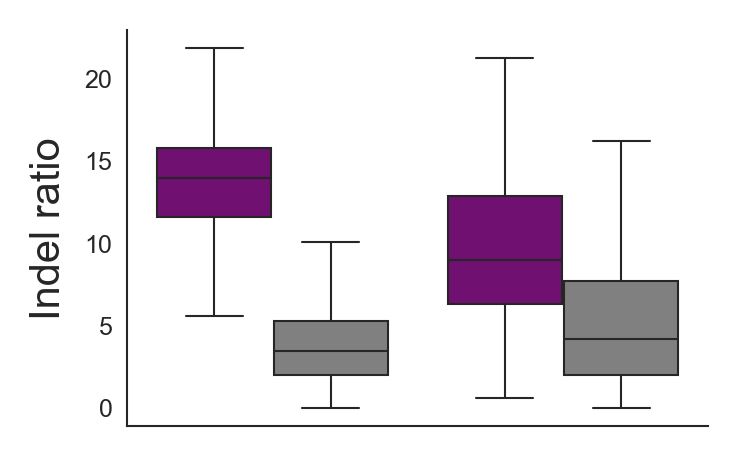

In [54]:
fig=plt.figure(figsize=(2.5,1.75))
ax=fig.add_subplot(1,1,1)
input_df=df2.copy()
x="MSI_associated_cancer"
y="indel_ratio"
hue="MRD"
ax=sns.boxplot(x=x,y=y,data=input_df,hue=hue,sym="",palette=["purple","grey"],order=[1,0],hue_order=[1,0])
ax.legend([])
ax.set_xlabel("")
ax.set_xticklabels([])
ax.set_ylabel("Indel ratio",fontsize=10)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(labelsize=6)

a=input_df[(input_df[x]==True)&(input_df[hue]==True)][y].values
b=input_df[(input_df[x]==True)&(input_df[hue]==False)][y].values
c=input_df[(input_df[x]==False)&(input_df[hue]==True)][y].values
d=input_df[(input_df[x]==False)&(input_df[hue]==False)][y].values

_,p1=stats.mannwhitneyu(a,b)
_,p2=stats.mannwhitneyu(c,d)

print("P= {:.2e}".format(p1))
print("P= {:.2e}".format(p2))

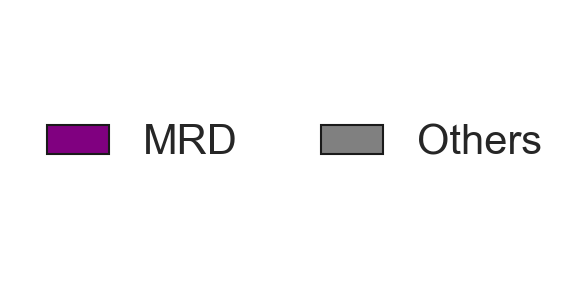

In [55]:
plt.figure(figsize=(1,1))
names=["MRD","Others"]
colors=["purple","grey"]
custom_legends =[  Patch(facecolor=colors[i],edgecolor="k",linewidth=0.5,
   			label=names[i]) for i in range(len(names)) ]
plt.legend(handles=custom_legends,loc="center",fontsize=10,ncol=2,handlelength=1.5)
plt.gca().set_axis_off()
#plt.savefig(store+"patch_smoking_status.png",dpi=300,bbox_inches="tight")

# POL

In [56]:
df2["POL"].sum()

81.0

/Users/takamatsushiro/.pyenv/versions/3.7.4/envs/MSigPred_2021/lib/python3.7/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


sPOLE_mut
MMR_mut
MLH1_methylation
MSI_high


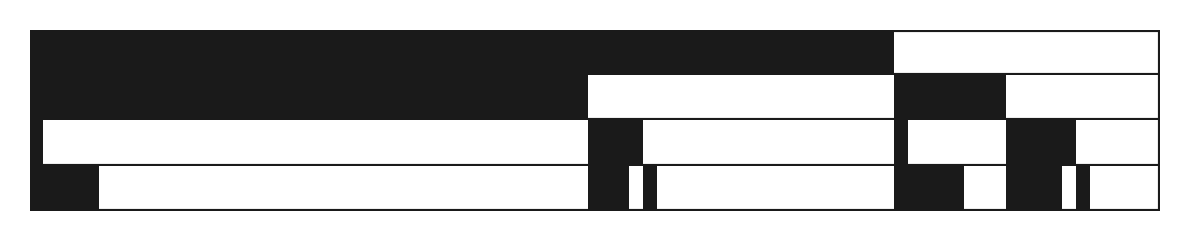

In [57]:
cat_list=["sPOLE_mut","MMR_mut","MLH1_methylation","MSI_high",]
n=len(cat_list)
input_df=df2[df2["POL"]==1]
input_df[cat_list]=input_df[cat_list].fillna(0)
input_df=input_df.sort_values(cat_list+["TMB_log10"],ascending=False)
N=input_df.shape[0]
fig=plt.figure(figsize=(N*0.06, 0.2*n))
for i,cat in enumerate(cat_list):
    ax=fig.add_subplot(n,1,i+1)
    print(cat)
    sns.heatmap(input_df[[cat]].T,cmap=wk,vmin=0,vmax=1,xticklabels=0,yticklabels=0,cbar=False,ax=ax)
    if i==0:
        ax.axhline(y=0, color='k',linewidth=1)
    ax.axhline(y=1, color='k',linewidth=1)
    ax.axvline(x=0, color='k',linewidth=1)
    ax.axvline(x=N, color='k',linewidth=1)
        
plt.subplots_adjust(hspace=0)
#plt.savefig(store+"heatmap_genomic.png",dpi=300,bbox_inches="tight")

In [58]:
pd.crosstab(df2["sPOLE_mut"],df2["POL"])

POL,0.0,1.0
sPOLE_mut,,
0.0,9711,19
1.0,2,62


In [59]:
df_pol=df2[df2["POL"]==1]
pd.crosstab(df_pol["sPOLE_mut"],df_pol["MMR_mut"])

MMR_mut,0.0,1.0
sPOLE_mut,,
0.0,11,8
1.0,22,40


In [60]:
tmp=df2[df2["POL"]==1].groupby("CancerType").count()["cluster_m2_names"].sort_values(ascending=False)
pd.DataFrame(tmp)

,cluster_m2_names
CancerType,
UCEC,54
CRC,13
BRCA,2
CESC,2
GBM,2
STAD,2
BLCA,1
ESCA,1
LGG,1


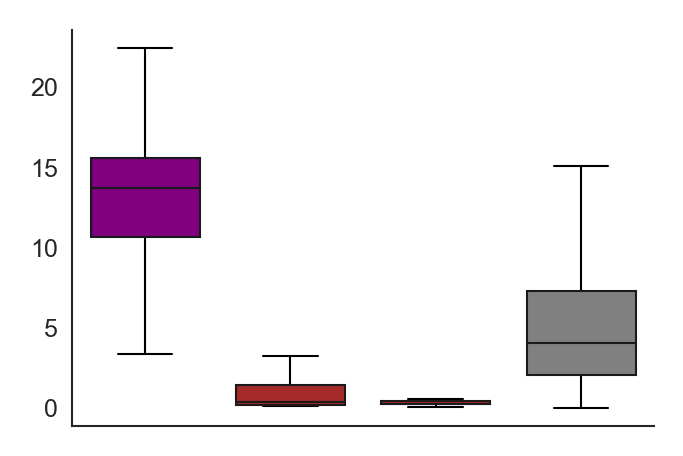

In [61]:
val="indel_ratio"
x1=df2[df2["MRD"]==1][val]
x2=df2[ (df2["POL"]==1)&((df2["MMR_mut"]==1)|(df2["MLH1_methylation"]==1))][val]
x3=df2[ (df2["POL"]==1)&((df2["MMR_mut"]!=1)&(df2["MLH1_methylation"]!=1))][val]
x4=df2[ ~df2["cluster_m2_names"].isin(["MRD","POL"])][val]
data_comp=[x1,x2,x3,x4]

fig = plt.figure(figsize=(2.5,1.75))
ax = fig.add_subplot(1,1,1)
bp=ax.boxplot(data_comp, showfliers=False, patch_artist=True,widths=0.75)
colors=["purple","brown","brown","grey"]
# box face color
for b, c in zip(bp['boxes'], colors):
    b.set(color=c, linewidth=0.5) 
    b.set_facecolor(c)
    b.set_edgecolor("k")
# median line
for b, c in zip(bp['medians'], colors):
    b.set(color="k",linewidth=0.5)
# whislers
for b, c in zip(bp['whiskers'], colors*2):
    b.set(linewidth=0.5)
# caps
for b, c in zip(bp['caps'], colors*2):
    b.set( linewidth=0.5)
    
        
ax.set_xticklabels([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(labelsize=6)

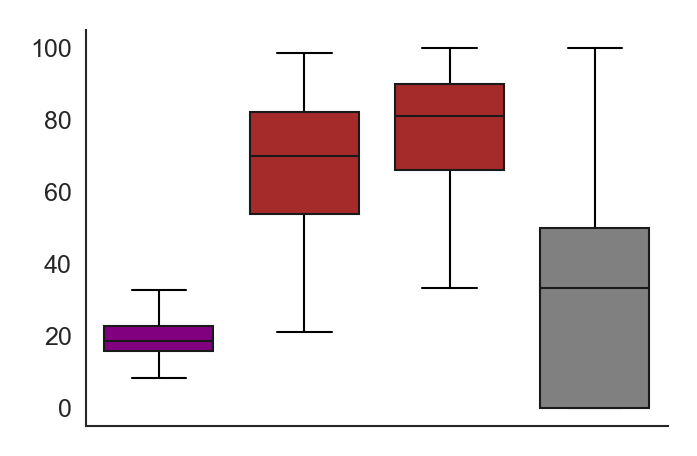

In [62]:
val="total_ins_indel_ratio"
x1=df2[df2["MRD"]==1][val]*100
x2=df2[ (df2["POL"]==1)&((df2["MMR_mut"]==1)|(df2["MLH1_methylation"]==1))][val]*100
x3=df2[ (df2["POL"]==1)&((df2["MMR_mut"]!=1)&(df2["MLH1_methylation"]!=1))][val]*100
x4=df2[ ~df2["cluster_m2_names"].isin(["MRD","POL"])][val]*100
x4=x4.dropna()
data_comp=[x1,x2,x3,x4]

fig = plt.figure(figsize=(2.5,1.75))
ax = fig.add_subplot(1,1,1)
bp = ax.boxplot(data_comp, showfliers=False, patch_artist=True, widths=0.75)
colors=["purple","brown","brown","grey"]
# box face color
for b, c in zip(bp['boxes'], colors):
    b.set(color=c, linewidth=0.5) 
    b.set_facecolor(c)
    b.set_edgecolor("k")
# median line
for b, c in zip(bp['medians'], colors):
    b.set(color="k",linewidth=0.5)
# whislers
for b, c in zip(bp['whiskers'], colors*2):
    b.set(linewidth=0.5)
# caps
for b, c in zip(bp['caps'], colors*2):
    b.set( linewidth=0.5)
    
ax.set_xticklabels([])

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(labelsize=6)

# HRD

In [63]:
df2["HRD"]=(df2["cluster_m2_names"]=="HRD").astype(float)
df2["ID6_ratio"]=df2["ID6"]/df2["total_all_mut"]*100
df_hrd=df2[df2["HRD"]==1]
len(df_hrd)

1956

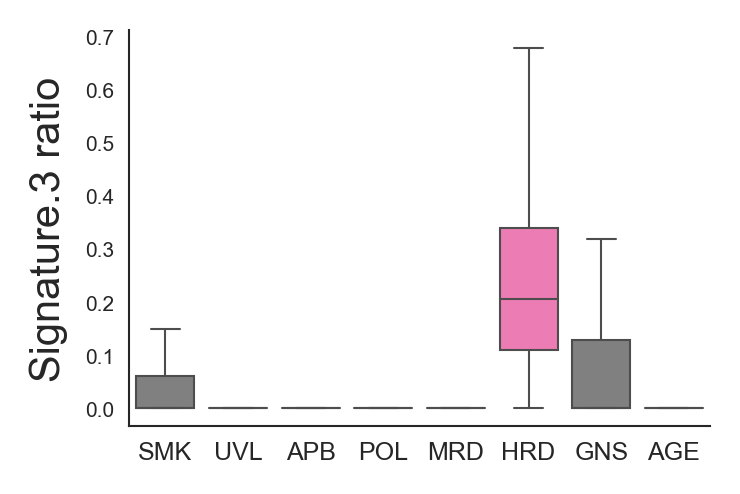

In [64]:
fig=plt.figure(figsize=(2.5,1.75))
ax=fig.add_subplot(111)
sns_df=df2.copy()
cat="cluster_m2_names"
val="Sig3_ratio"
colors=["grey"]*5+["hotpink"]+["grey"]*2
ax=sns.boxplot(x=cat,y=val,data=sns_df,sym="",boxprops={"alpha":1},palette=colors)
#sns.swarmplot(x=cat,y=val,data=sns_df)
ax.set_xlabel("")
ax.set_ylabel("Signature.3 ratio",fontsize=10)
ax.set_title("",fontsize=10)
ax.tick_params(axis="y",labelsize=5)
ax.tick_params(axis="x",labelsize=6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

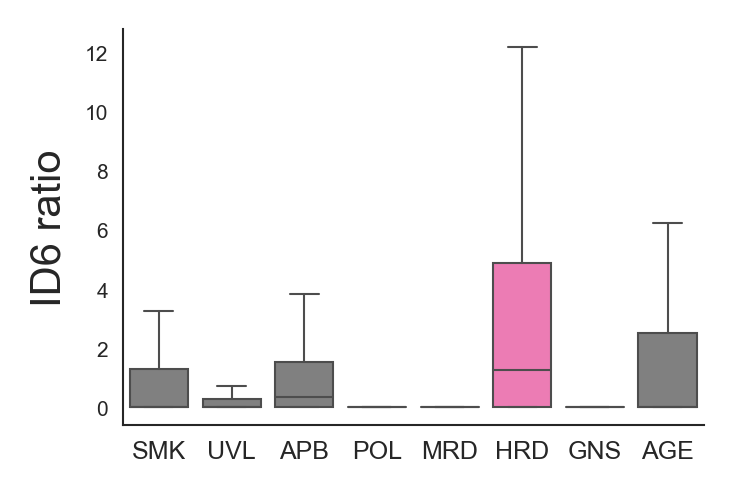

In [65]:
fig=plt.figure(figsize=(2.5,1.75))
ax=fig.add_subplot(111)
sns_df=df2.copy()
cat="cluster_m2_names"
val="ID6_ratio"
colors=["grey"]*5+["hotpink"]+["grey"]*2
ax=sns.boxplot(x=cat,y=val,data=sns_df,sym="",boxprops={"alpha":1},palette=colors)
#sns.swarmplot(x=cat,y=val,data=sns_df)
ax.set_xlabel("")
ax.set_ylabel("ID6 ratio",fontsize=10)
ax.set_title("",fontsize=10)
ax.tick_params(axis="y",labelsize=5)
ax.tick_params(axis="x",labelsize=6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [66]:
counter_order=Counter(df_hrd["CancerType"]).most_common()
counter_order

[('OV', 315),
 ('BRCA', 297),
 ('KIRC', 177),
 ('KIRP', 152),
 ('SARC', 107),
 ('LIHC', 90),
 ('UCEC', 86),
 ('GBM', 79),
 ('STAD', 64),
 ('PRAD', 61),
 ('CRC', 60),
 ('HNSC', 59),
 ('LUAD', 53),
 ('LGG', 50),
 ('BLCA', 41),
 ('MESO', 36),
 ('LUSC', 33),
 ('ESCA', 30),
 ('THCA', 26),
 ('ACC', 24),
 ('SKCM', 23),
 ('UCS', 19),
 ('CESC', 17),
 ('CHOL', 15),
 ('PAAD', 14),
 ('TGCT', 9),
 ('UVM', 8),
 ('KICH', 6),
 ('PCPG', 5)]

In [67]:
cancer_order=[ cancer[0] for cancer in counter_order]
count_order=[ cancer[1] for cancer in counter_order]

In [68]:
sns_df=df_hrd.groupby("CancerType").mean()[["Sig3_ratio","HRD_score","ID6_ratio"]].loc[cancer_order,:]
sns_df["CancerType"]=sns_df.index
sns_df

,Sig3_ratio,HRD_score,ID6_ratio,CancerType
CancerType,,,,
OV,0.377426,49.214286,4.973415,OV
BRCA,0.249279,37.426056,6.344621,BRCA
KIRC,0.232733,5.883721,1.256977,KIRC
KIRP,0.237103,2.820000,2.180681,KIRP
SARC,0.208390,35.852941,3.645910,SARC
LIHC,0.141566,19.552941,2.879989,LIHC
UCEC,0.213650,33.776471,3.902552,UCEC
GBM,0.310930,8.813333,0.300196,GBM
STAD,0.207964,39.460317,5.953342,STAD


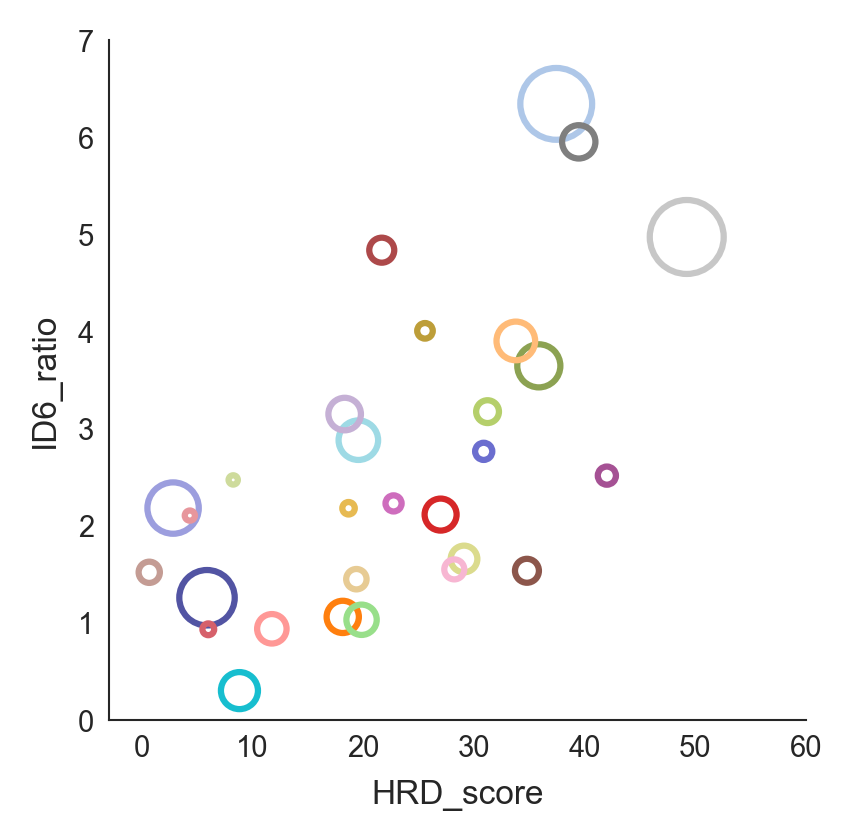

In [69]:
fig=plt.figure(figsize=(3,3))
ax=fig.add_subplot(111)
tmp_df=sns_df.copy()
val1,val2="HRD_score","ID6_ratio"
colors=[dict_cancer_colors[cancer] for cancer in cancer_order]
x=tmp_df[val1]
y=tmp_df[val2]
ax.scatter(x,y,s=count_order,ec=colors,fc="None",lw=1.5)
ax.set_xlabel(val1)
ax.set_ylabel(val2)
ax.set_ylim(0,7)
ax.set_xlim(-3,60)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

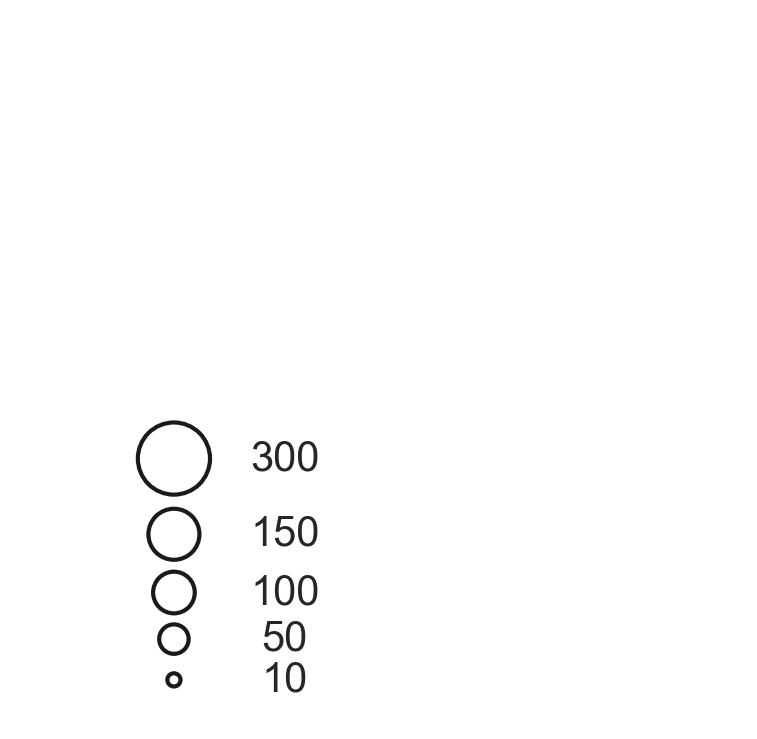

In [70]:
fig=plt.figure(figsize=(3,3))
ax=fig.add_subplot(111)
colors=["k"]
x=[10,10,10,10,10]
y=np.array([0.5,1.2,2,3,4.3])*0.6
ax.scatter(x,y,s=[10,50,100,150,300],ec=colors,fc="None",lw=1)

x2=[20,20,20,20,20]
texts=[10,50,100,150,300]
for i in range(len(x2)):
    ax.text( x2[i],y[i],s=texts[i], va="center", ha="center")

ax.set_xlabel(val1)
ax.set_ylabel(val2)
ax.set_ylim(0,7)
ax.set_xlim(-3,60)
ax.set_axis_off()

In [72]:
len(cancer_order)

29

In [71]:
x=np.arange(0,6)
y=np.arange(0,5)
xx,yy=np.meshgrid(x,y)

/Users/takamatsushiro/.pyenv/versions/3.7.4/envs/MSigPred_2021/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


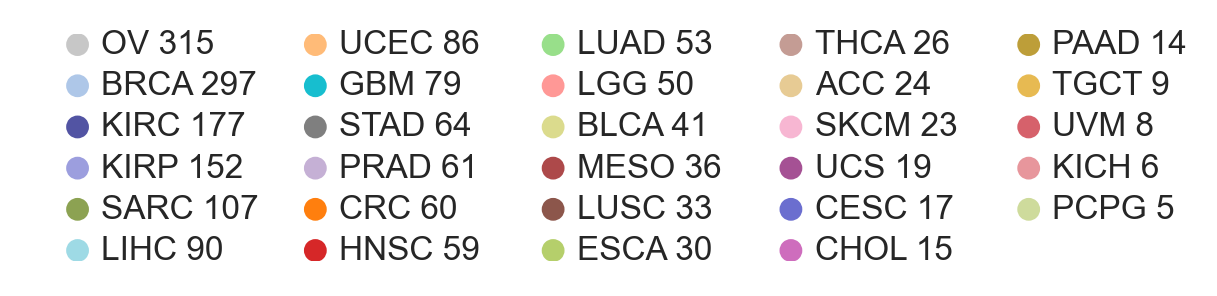

In [73]:
fig=plt.figure(figsize=(4.5,1))
ax=fig.add_subplot(111)
colors=[dict_cancer_colors[cancer] for cancer in cancer_order]

cancer_order_count=[x+" "+str(y) for x,y in zip(cancer_order,count_order) ]

ax.scatter(yy,xx,s=20,c=colors+["w"],lw=1)
for i in range(5):
    for j in range(6):
        if (i==4) & (j==5):
            continue
        else:
            ax.annotate(xy=(i+0.1,j),text=cancer_order_count[6*i+j],fontsize=8,ha="left",va="center")
ax.set_axis_off()
ax.invert_yaxis()

# GNS

In [74]:
df2["GNS"]=(df2["cluster_m2_names"]=="GNS").astype(float)
df2["GNS"].sum()

909.0

P= 1.43e-241


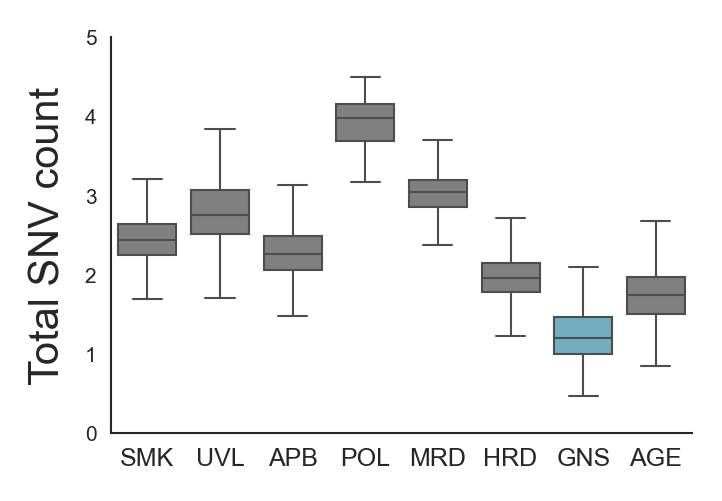

In [75]:
df2["total_all_snv_log10"]=np.log10(df2["total_all_snv"]+1)
fig=plt.figure(figsize=(2.5,1.75))
ax=fig.add_subplot(111)
sns_df=df2.copy()
cat="cluster_m2_names"
val="total_all_snv_log10"
colors=["grey"]*6+["c"]+["grey"]
ax=sns.boxplot(x=cat,y=val,data=sns_df,sym="",boxprops={"alpha":1},palette=colors)
#sns.swarmplot(x=cat,y=val,data=sns_df)
ax.set_xlabel("")
ax.set_ylabel("Total SNV count",fontsize=10)
ax.set_title("",fontsize=10)
ax.tick_params(axis="y",labelsize=5)
ax.tick_params(axis="x",labelsize=6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_yticks([0,1,2,3,4,5])

a=sns_df[sns_df[cat]=="GNS"][val].values
b=sns_df[sns_df[cat]=="AGE"][val].values
res=stats.mannwhitneyu(a,b)
print("P= {:.2e}".format(res[1]))

P= 1.20e-84


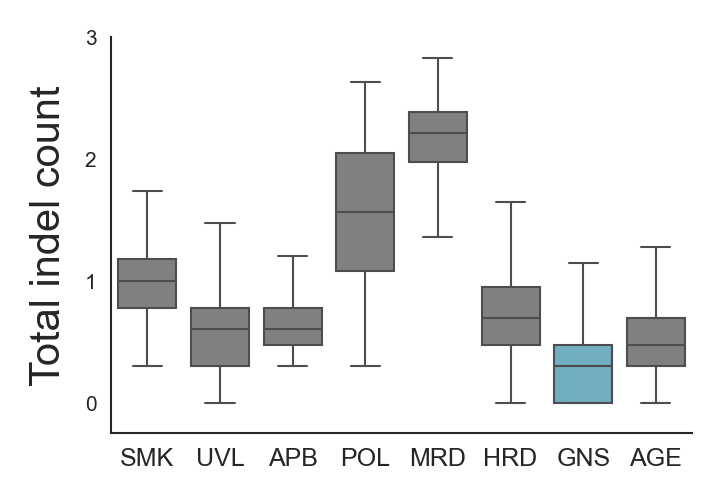

In [76]:
fig=plt.figure(figsize=(2.5,1.75))
ax=fig.add_subplot(111)
sns_df=df2.copy()
cat="cluster_m2_names"
val="indel_count_log10"
colors=["grey"]*6+["c"]+["grey"]
ax=sns.boxplot(x=cat,y=val,data=sns_df,sym="",boxprops={"alpha":1},palette=colors)
#sns.swarmplot(x=cat,y=val,data=sns_df)
ax.set_xlabel("")
ax.set_ylabel("Total indel count",fontsize=10)
ax.set_title("",fontsize=10)
ax.tick_params(axis="y",labelsize=5)
ax.tick_params(axis="x",labelsize=6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_yticks([0,1,2,3])
ax.set_ylim(-0.25,3)

a=sns_df[sns_df[cat]=="GNS"][val].values
b=sns_df[sns_df[cat]=="AGE"][val].values
res=stats.mannwhitneyu(a,b)
print("P= {:.2e}".format(res[1]))

# AGE

In [77]:
df2["AGE"]=(df2["cluster_m2_names"]=="AGE").astype(float)
df2["AGE"].sum()

4000.0

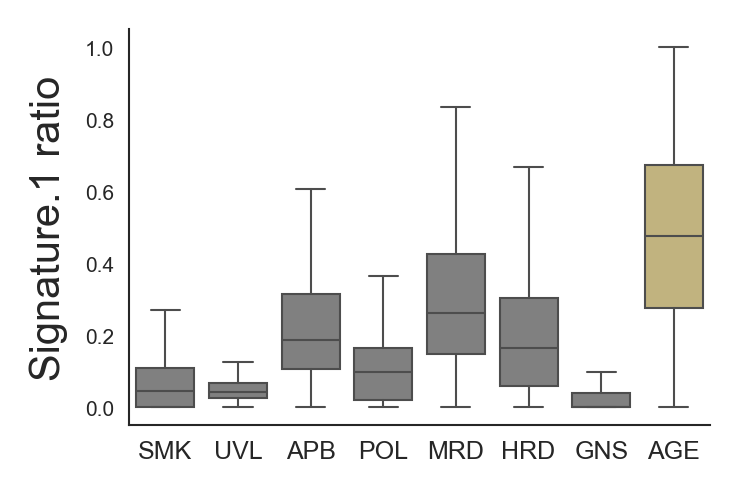

In [78]:
fig=plt.figure(figsize=(2.5,1.75))
ax=fig.add_subplot(111)
sns_df=df2.copy()
cat="cluster_m2_names"
val="Sig1_ratio"
colors=["grey"]*7+["y"]
ax=sns.boxplot(x=cat,y=val,data=sns_df,sym="",boxprops={"alpha":1},palette=colors)
#sns.swarmplot(x=cat,y=val,data=sns_df)
ax.set_xlabel("")
ax.set_ylabel("Signature.1 ratio",fontsize=10)
ax.set_title("",fontsize=10)
ax.tick_params(axis="y",labelsize=5)
ax.tick_params(axis="x",labelsize=6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [79]:
df["Sig1_ratio"]=df["Sig_1"]/df["total_Sig_count"]*100
df["Sig2_ratio"]=df["Sig_2"]/df["total_Sig_count"]*100
df["Sig13_ratio"]=df["Sig_13"]/df["total_Sig_count"]*100
df["Sig4_ratio"]=df["Sig_4"]/df["total_Sig_count"]*100
df["Sig7_ratio"]=df["Sig_7"]/df["total_Sig_count"]*100
df["Sig6_ratio"]=df["Sig_6"]/df["total_Sig_count"]*100
df["Sig15_ratio"]=df["Sig_15"]/df["total_Sig_count"]*100
df["Sig20_ratio"]=df["Sig_20"]/df["total_Sig_count"]*100
df["Sig26_ratio"]=df["Sig_26"]/df["total_Sig_count"]*100
df["Sig10_ratio"]=df["Sig_10"]/df["total_Sig_count"]*100
df["Sig3_ratio"]=df["Sig_3"]/df["total_Sig_count"]*100

In [80]:
sig_ratios=[ "Sig"+str(x)+"_ratio" for x in [4,7,2,10,6,3,1]]
irs=["CD8A_log_z","GZMB_log_z","IFNG_log_z","PDCD1_log_z","CTLA4_log_z",
           "CYT_log_z","GEP_score_z",]

In [81]:
dict_sig_val_cor={}
for val in irs:
    dict_sig_val_cor[val]={}
    for sig in sig_ratios:
        x=df[val]    
        y=df[sig]
        r,p=stats.spearmanr(x,y,nan_policy="omit")
        dict_sig_val_cor[val][sig]=r   

In [82]:
dict_sig_val_cor2={}
for val in irs:
    dict_sig_val_cor2[val]={}
    for sig in sig_ratios:
        x=df[val]    
        y=df[sig]
        r,p=stats.spearmanr(x,y,nan_policy="omit")
        dict_sig_val_cor2[val][sig]=p

In [83]:
dfr=pd.DataFrame(dict_sig_val_cor).T
dfp=pd.DataFrame(dict_sig_val_cor2).T
dfp_log10=np.log10(dfp)
dfp

,Sig4_ratio,Sig7_ratio,Sig2_ratio,Sig10_ratio,Sig6_ratio,Sig3_ratio,Sig1_ratio
CD8A_log_z,9.250409e-23,1.575022e-21,5.520032e-31,8.470527e-12,2.472839e-01,0.012152,1.995009e-88
GZMB_log_z,1.320602e-36,3.017437e-40,8.280373e-56,5.914055e-26,1.458190e-15,0.711616,8.051785e-51
IFNG_log_z,2.202011e-30,4.258601e-37,3.916979e-46,3.370157e-22,2.344305e-03,0.759465,2.333077e-84
PDCD1_log_z,7.000298e-21,4.032666e-24,2.310074e-24,8.720799e-11,1.135919e-04,0.044536,1.050873e-76
CTLA4_log_z,5.815317e-21,1.015093e-57,4.418017e-62,6.066289e-26,2.508238e-07,0.000515,5.750279e-41
CYT_log_z,4.155592e-35,2.803192e-22,7.501304e-34,2.803781e-10,3.066789e-05,0.000013,2.918869e-90
GEP_score_z,1.734987e-37,3.563963e-38,3.019751e-55,5.423197e-16,4.033587e-02,0.000037,2.079775e-96


In [84]:
bold1=dfp_log10 > -4
mask1=dfp>0.05

CD8A
GZMB
IFNG
PDCD1
CTLA4
CYT
GEP_score_z


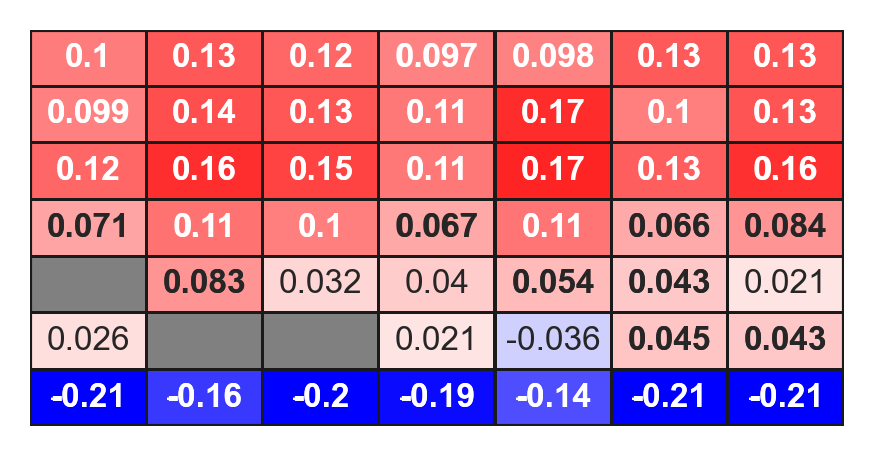

In [85]:
fig=plt.figure(figsize=(3.5,1.75))
ax=fig.add_subplot(111)
sns_df=dfr.T

ax=sns.heatmap(data=sns_df,cmap=bwr,vmin=-0.2,vmax=0.2,annot=sns_df
           ,fmt=".2g",annot_kws={"fontsize":8,"weight":100},cbar=False
           ,yticklabels=0,xticklabels=0
            ,mask=mask1.T, linewidths=0.5, linecolor='k')


ax=sns.heatmap(data=sns_df,cmap=bwr,vmin=-0.2,vmax=0.2,annot=sns_df
           ,fmt=".2g",annot_kws={"fontsize":8,"weight":1000},cbar=False
           ,yticklabels=0,xticklabels=0
            ,mask=bold1.T,linewidths=0.5, linecolor='k')

ax.axvline(x=0, color='k',linewidth=1)
ax.axvline(x=sns_df.shape[1], color='k',linewidth=1)
ax.axhline(y=0, color='k',linewidth=1)
ax.axhline(y=sns_df.shape[0], color='k',linewidth=1)

ax.set_facecolor("grey")

for i in sns_df.columns:
    print(i.replace("_log_z",""))